# ABUNDANCE DERIVATIONS WITH THE DIRECT METHOD

## The chemical composition of IC 2165 (See previous Notebook)

## The chemical composition of giant HII regions NGC 300.

Bresolin et al. 2009, have observed 20 giant H II regions in the spiral galaxy NGC 300.

##### We first import needed libraries

In [1]:
%matplotlib inline
import pyneb as pn
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Column

### Compute the electron densities and temperatures from all the available ratios

##### We read the observations into a PyNeb Observation object. Notice that in this file the errors are absolutes.

In [2]:
obs = pn.Observation('../Data/NGC300.dat', corrected=True, errIsRelative=False)
# the galactocentric distance has been also read and the values are in "obsIntens"
# with a label that does not correspond to a line (warning is issued, 
# it's a normal behaviour).
Rgal = obs.getLine(label='DIST').obsIntens

warng EmissionLine: line 9015A for atom H1r not valid
warng EmissionLine: Atom Dist not valid


##### We instanciate the Diagnostic object.

In [3]:
diags = pn.Diagnostics()

##### We set up the diagnostics according to the available emission lines.

In [4]:
diags.addDiagsFromObs(obs)

##### We check which diagnostics have been selected.

In [5]:
diags.diags

{'[NII] 5755/6584': ('N2', 'L(5755)/L(6584)', 'RMS([E(6584), E(5755)])'),
 '[OIII] 4363/5007': ('O3', 'L(4363)/L(5007)', 'RMS([E(5007), E(4363)])'),
 '[SIII] 6312/9069': ('S3', 'L(6312)/L(9069)', 'RMS([E(9069), E(6312)])'),
 '[SII] 6731/6716': ('S2', 'L(6731)/L(6716)', 'RMS([E(6716), E(6731)])')}

##### We check which Atoms have been instantiated in the Diagnostic object. 

In [6]:
diags.atomDict

{'N2': Atom N2 from n_ii_atom_FFT04.dat and n_ii_coll_T11.dat,
 'O3': Atom O3 from o_iii_atom_FFT04-SZ00.dat and o_iii_coll_SSB14.dat,
 'S2': Atom S2 from s_ii_atom_PKW09.dat and s_ii_coll_TZ10.dat,
 'S3': Atom S3 from s_iii_atom_PKW09.dat and s_iii_coll_TG99.dat}

In [7]:
# Clean the pypics files, because we will change the boundaries.
pn.utils.misc.cleanPypicFiles(all_=True)
# we can choose to do the diagnostic plots of the whole set of observations
emisgrids = pn.getEmisGridDict(atomDict=diags.atomDict, n_tem=100, n_den=100, 
                               tem_min=5000., tem_max=15000., 
                               den_min=10., den_max=1e5)

warng getEmisGridDict: Emission map not found: ./pypics//emis_N2.pypic
warng getEmisGridDict: Emission map not found: ./pypics//emis_O3.pypic
warng getEmisGridDict: Emission map not found: ./pypics//emis_S2.pypic
warng getEmisGridDict: Emission map not found: ./pypics//emis_S3.pypic


##### We plot all the diagnostics diagrams.

/Users/christophemorisset/anaconda/envs/py3k6/lib/python3.6/site-packages/pyneb/core/diags.py:543: RuntimeWarning: invalid value encountered in double_scalars
  levels = [(1 - tol_value) * diag_value, (1 + tol_value) * diag_value]


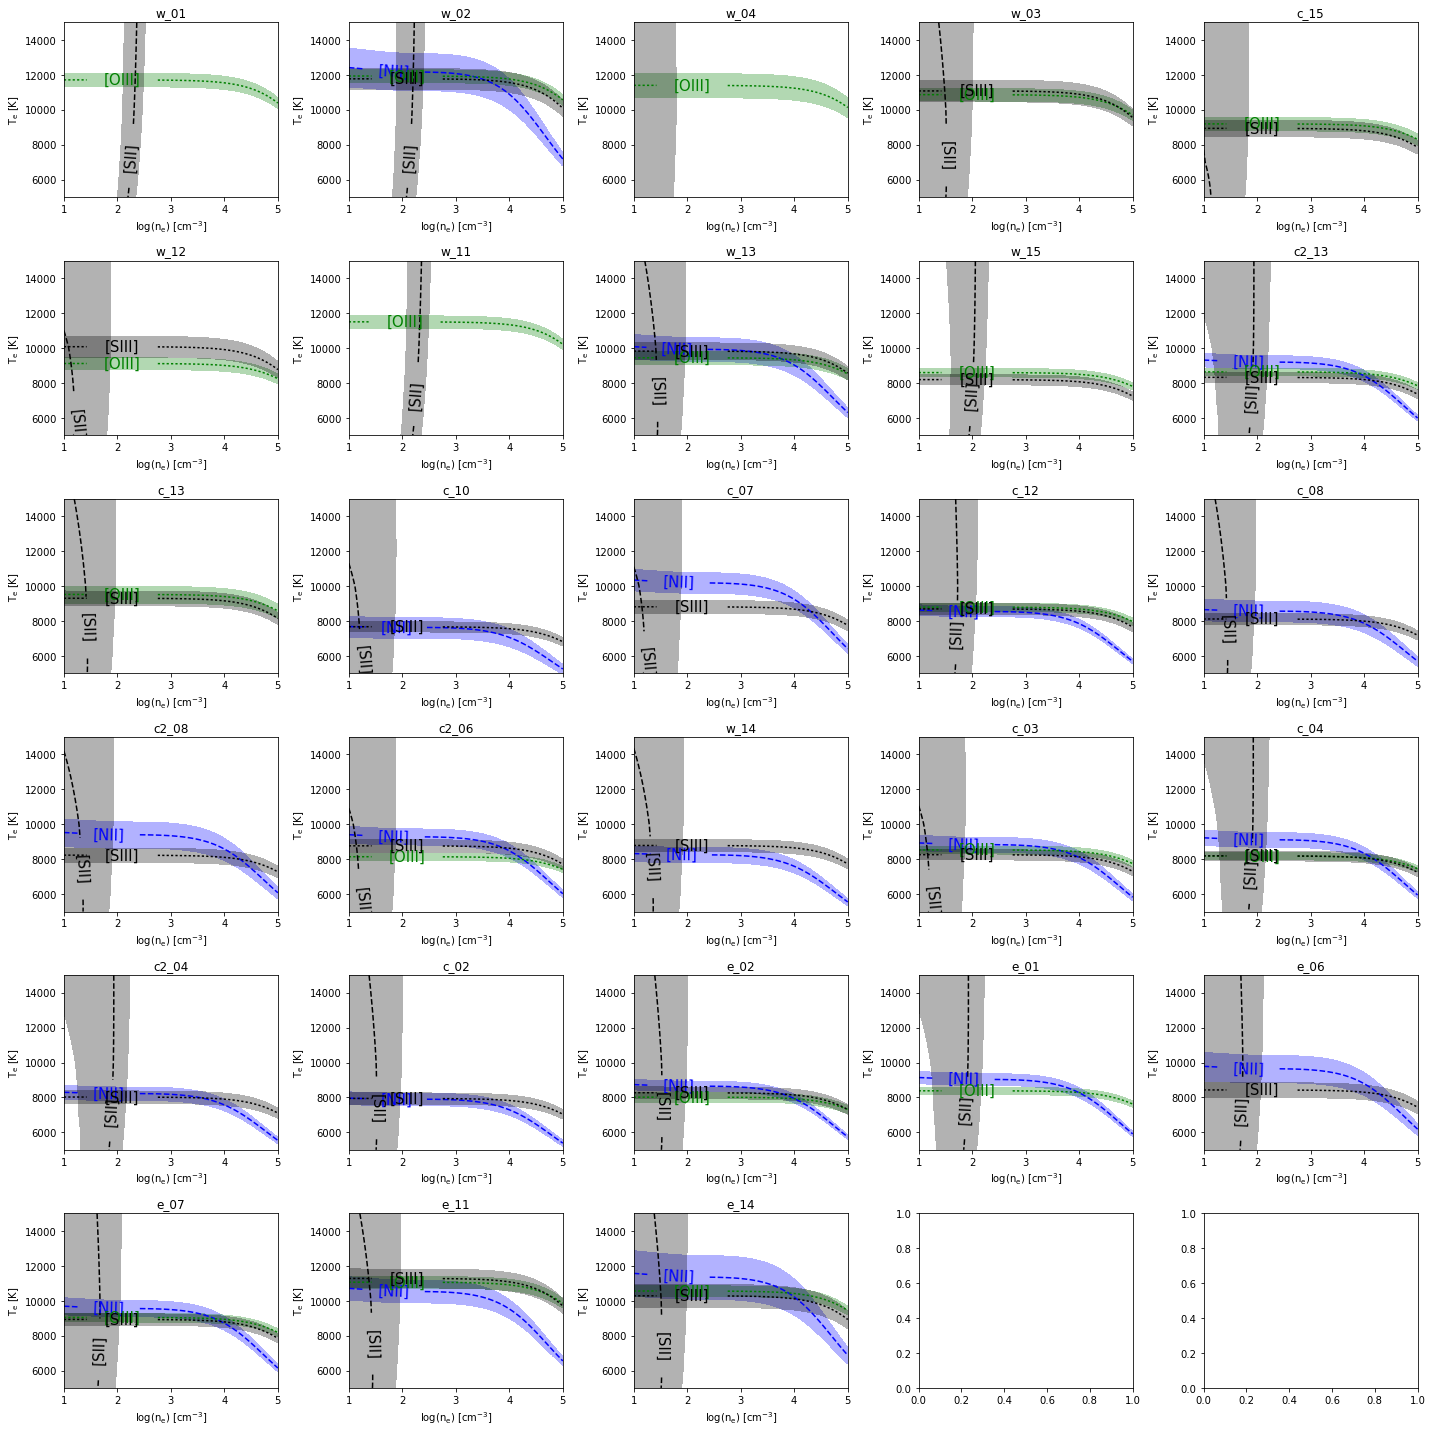

In [8]:
# We can see which diagnostic to use for Te and for Ne determinations
f, axes = plt.subplots(6, 5, figsize=(20, 20))
for i, obs_name in enumerate(obs.names):
    ax = axes.ravel()[i]
    diags.plot(emisgrids, obs, i_obs=i, ax=ax)
    ax.set_title(obs_name)
f.tight_layout()
f.savefig('diags.pdf')

##### We determine Te and Ne by intersection of 2 diagnostics.

In [9]:
pn.log_.level = 3
temp_O3, dens_S2a = diags.getCrossTemDen('[OIII] 4363/5007', '[SII] 6731/6716', 
                                         obs=obs)
temp_S3, dens_S2b = diags.getCrossTemDen('[SIII] 6312/9069', '[SII] 6731/6716', 
                                         obs=obs)
temp_N2, dens_S2c = diags.getCrossTemDen('[NII] 5755/6584', '[SII] 6731/6716', 
                                         obs=obs)

/Users/christophemorisset/anaconda/envs/py3k6/lib/python3.6/site-packages/pyneb/core/diags.py:695: RuntimeWarning: invalid value encountered in greater
  no_conv = ((abs(den_old - den) / den * 100) > tol_den) | ((abs(tem_old - tem) / tem * 100) > tol_tem)


     Diag.getCrossTemDen [OIII] 4363/5007 [SII] 6731/6716: 0 (max=5): not converged 16 of 28.
     Diag.getCrossTemDen [OIII] 4363/5007 [SII] 6731/6716: 1 (max=5): not converged 0 of 28.
     Diag.getCrossTemDen [SIII] 6312/9069 [SII] 6731/6716: 0 (max=5): not converged 19 of 28.
     Diag.getCrossTemDen [SIII] 6312/9069 [SII] 6731/6716: 1 (max=5): not converged 0 of 28.
     Diag.getCrossTemDen [NII] 5755/6584 [SII] 6731/6716: 0 (max=5): not converged 14 of 28.
     Diag.getCrossTemDen [NII] 5755/6584 [SII] 6731/6716: 1 (max=5): not converged 0 of 28.


In [10]:
print(temp_O3)

[ 11702.44697878  11927.31540013             nan  10859.32987543
   9185.05406875   9106.73472828  11492.22924449   9434.39095208
   8587.27609943   8626.27952762   9519.84133404             nan
             nan   8792.0378398              nan             nan
   8143.44734503             nan   8532.83405336   8177.11193172
             nan             nan   8014.30098704   8379.68483021
             nan   9040.51905417  11062.98280776  10556.07333353]


##### In the cases where the density is not defined, we choose to set it to 10 and compute new Te.

In [11]:
pn.log_.level = 1
mask_nan = np.isnan(dens_S2a)
dens_S2a[mask_nan] = 10.
O3 = pn.Atom('O', 3)
temp_O3[mask_nan] = O3.getTemDen((obs.getLine(label='O3_4363A').corrIntens/
                                  obs.getLine(label='O3_5007A').corrIntens)[mask_nan], 
                                  den=10, wave1=4363, wave2=5007)
mask_nan = np.isnan(dens_S2b)
dens_S2b[mask_nan] = 10.
S3 = pn.Atom('S', 3)
temp_S3[mask_nan] = S3.getTemDen((obs.getLine(label='S3_6312A').corrIntens/
                                  obs.getLine(label='S3_9069A').corrIntens)[mask_nan], 
                                  den=10, wave1=6312, wave2=9069)
mask_nan = np.isnan(dens_S2c)
dens_S2c[mask_nan] = 10.
N2 = pn.Atom('N', 2)
temp_N2[mask_nan] = N2.getTemDen((obs.getLine(label='N2_5755A').corrIntens/
                                  obs.getLine(label='N2_6584A').corrIntens)[mask_nan], 
                                  den=10, wave1=5755, wave2=6583)
    
# Here we adopt an average value of the 3 densities
mean_dens = (dens_S2a + dens_S2b + dens_S2c) / 3

##### We determine electron temperatures from O2 and S2 from the previously determined S2 densities.

In [12]:
O2 = pn.Atom('O', 2)
temp_O2 = O2.getTemDen((obs.getLine(label='O2_3727A+').corrIntens/
                        obs.getLine(label='O2_7325A+').corrIntens),
                        den = mean_dens, 
                        to_eval = '(L(3726)+L(3729))/(I(4,2)+I(5,2)+I(4,3)+I(5,3))')
S2 = pn.Atom('S', 2)
temp_S2 = S2.getTemDen((obs.getLine(label='S2_4072A+').corrIntens/
                        obs.getLine(label='S2_6716A').corrIntens),
                        den = mean_dens, 
                        to_eval = '(L(4076)+L(4069))/L(6716)')

##### We instantiate a Table object (Table as been previously imported from astropy).

In [13]:
T = Table()

##### We add the columns with their names into T

In [14]:
T.add_columns([Column(obs.names, name='NAME'), 
               Column(temp_O2, name='T_O2'),
               Column(temp_S2, name='T_S2'),
               Column(temp_N2, name='T_N2'),
               Column(temp_O3, name='T_O3')])

##### We pretty print the table T.

In [15]:
print(T)

 NAME      T_O2          T_S2          T_N2          T_O3    
----- ------------- ------------- ------------- -------------
 w_01 12764.1060987 21532.6165167           nan 11702.4469788
 w_02 12351.5561726 13621.7032781 12165.4636263 11927.3154001
 w_04 12102.2250896 12897.1413656           nan 11398.8673552
 w_03  11817.692877 12805.5879828           nan 10859.3298754
 c_15 10173.3123919 12128.9051525           nan 9185.05406875
 w_12 9822.21876452 16219.3274823           nan 9106.73472828
 w_11 13939.4409517 21463.9609334           nan 11492.2292445
 w_13 9548.11098605 10245.3624702 9998.48954123 9434.39095208
 w_15 10653.9929026  11243.681228           nan 8587.27609943
c2_13 8578.52466014 12669.4750527 9198.25838426 8626.27952762
  ...           ...           ...           ...           ...
 w_14  11552.931473 8392.61161552 8292.82790415           nan
 c_03 8481.88447745 13671.9898539 8915.36910158 8532.83405336
 c_04 9695.07814846 10840.9025205 9122.63847045 8177.11193172
c2_04 99

##### We print the table T in an ascii file

In [17]:
T.write('temperatures1.ascii', format='ascii.fixed_width', overwrite=True)
# writing to a second file with another format
T.write('temperatures2.ascii', format='ascii.fixed_width',
        formats={'NAME':'%5s', 'T_O2': '%7.1f', 'T_N2': '%7.1f', 'T_S2':'%7.1f', 
                 'T_O3':'%7.1f'}, overwrite=True)

In [18]:
!cat temperatures2.ascii

|  NAME |    T_O2 |    T_S2 |    T_N2 |    T_O3 |
|  w_01 | 12764.1 | 21532.6 |     nan | 11702.4 |
|  w_02 | 12351.6 | 13621.7 | 12165.5 | 11927.3 |
|  w_04 | 12102.2 | 12897.1 |     nan | 11398.9 |
|  w_03 | 11817.7 | 12805.6 |     nan | 10859.3 |
|  c_15 | 10173.3 | 12128.9 |     nan |  9185.1 |
|  w_12 |  9822.2 | 16219.3 |     nan |  9106.7 |
|  w_11 | 13939.4 | 21464.0 |     nan | 11492.2 |
|  w_13 |  9548.1 | 10245.4 |  9998.5 |  9434.4 |
|  w_15 | 10654.0 | 11243.7 |     nan |  8587.3 |
| c2_13 |  8578.5 | 12669.5 |  9198.3 |  8626.3 |
|  c_13 | 12088.5 | 12692.8 |     nan |  9519.8 |
|  c_10 |  8395.8 |  8669.2 |  7669.0 |     nan |
|  c_07 |  8641.9 | 11030.3 | 10327.4 |     nan |
|  c_12 | 10892.0 |  8980.3 |  8556.3 |  8792.0 |
|  c_08 | 10199.3 |  9686.1 |  8606.8 |     nan |
| c2_08 |  9623.9 | 14276.1 |  9486.0 |     nan |
| c2_06 |  8434.0 |  9869.9 |  9388.0 |  8143.4 |
|  w_14 | 11552.9 |  8392.6 |  8292.8 |     nan |
|  c_03 |  8481.9 | 13672.0 |  8915.4 |  8532.8 |


##### We print the table T in a latex file

In [20]:
T.write('temperatures.tex', format='ascii.latex',
        formats={'NAME':'%5s', 'T_O2': '%7.1f', 'T_N2': '%7.1f', 'T_S2':'%7.1f', 
                 'T_O3':'%7.1f'}, overwrite=True)
# test anither format
T.write('temperatures2.tex', format='ascii.aastex',
        formats={'NAME':'%5s', 'T_O2': '%7.1f', 'T_N2': '%7.1f', 'T_S2':'%7.1f', 
                 'T_O3':'%7.1f'}, overwrite=True)

In [21]:
!cat temperatures.tex

\begin{table}
\begin{tabular}{ccccc}
NAME & T_O2 & T_S2 & T_N2 & T_O3 \\
w_01 & 12764.1 & 21532.6 & nan & 11702.4 \\
w_02 & 12351.6 & 13621.7 & 12165.5 & 11927.3 \\
w_04 & 12102.2 & 12897.1 & nan & 11398.9 \\
w_03 & 11817.7 & 12805.6 & nan & 10859.3 \\
c_15 & 10173.3 & 12128.9 & nan & 9185.1 \\
w_12 & 9822.2 & 16219.3 & nan & 9106.7 \\
w_11 & 13939.4 & 21464.0 & nan & 11492.2 \\
w_13 & 9548.1 & 10245.4 & 9998.5 & 9434.4 \\
w_15 & 10654.0 & 11243.7 & nan & 8587.3 \\
c2_13 & 8578.5 & 12669.5 & 9198.3 & 8626.3 \\
c_13 & 12088.5 & 12692.8 & nan & 9519.8 \\
c_10 & 8395.8 & 8669.2 & 7669.0 & nan \\
c_07 & 8641.9 & 11030.3 & 10327.4 & nan \\
c_12 & 10892.0 & 8980.3 & 8556.3 & 8792.0 \\
c_08 & 10199.3 & 9686.1 & 8606.8 & nan \\
c2_08 & 9623.9 & 14276.1 & 9486.0 & nan \\
c2_06 & 8434.0 & 9869.9 & 9388.0 & 8143.4 \\
w_14 & 11552.9 & 8392.6 & 8292.8 & nan \\
c_03 & 8481.9 & 13672.0 & 8915.4 & 8532.8 \\
c_04 & 9695.1 & 10840.9 & 9122.6 & 8177.1 \\
c2_04 & 9945.4 & 11778.0 & 8224.7 & nan \\
c_02 & 

### Use Bresolin’s et al policy to derive the electron temperature in the low- and high-excitation zones of each object.

##### We use a copy of the arrays, as we will have to modify them and don't want to touch the original data.

In [22]:
tS3 = temp_S3.copy()
tO3 = temp_O3.copy()
# we define 3 Te for low, mid and high ionization regions
Tmid = tS3
mask_nan = np.isnan(tS3)
Tmid[mask_nan] = tO3[mask_nan] * 0.83 + 1700
    
Thigh = tO3
mask_nan = np.isnan(tO3)
Thigh[mask_nan] = (tS3[mask_nan] - 1700) / 0.83
    
#Tlow = (temp_S2+temp_O2) / 2.    
Tlow = Thigh*0.7 + 3000

print(Tlow, Tmid, Thigh)

[ 11191.71288514  11349.12078009  10979.20714861  10601.5309128
   9429.53784812   9374.7143098   11044.56047114   9604.07366646
   9011.0932696    9038.39566933   9663.88893383   8038.1308292
   9002.63949311   9154.42648786   8411.80299422   8510.03707181
   8700.41314152   8978.92901537   8972.98383735   8723.97835221
   8329.89591709   8264.58277061   8610.01069093   8865.77938115
   8675.73868421   9328.36333792  10744.08796543  10389.25133347] [ 11413.03099238  11766.45669908  11161.05990478  11073.72930299
   8929.67606529  10068.21589335  11238.55027293   9816.6591791
   8180.91031958   8314.631437     9305.91742858   7673.78369749
   8817.41539898   8692.67474403   8116.85212171   8233.32967086
   8767.73651891   8789.30154679   8259.66516659   8192.97739344
   8019.73373026   7942.29099944   8269.81661892   8655.13840908
   8429.80443985   8929.67606529  11274.10528386  10280.6589486 ] [ 11702.44697878  11927.31540013  11398.86735516  10859.32987543
   9185.05406875   9106.73

### Compute the ionic abundances for N, O, Ne for all the objects.

In [24]:
#we associate the Te with each ion
Te_dic = {'N2' : Tlow,
              'O2' : Tlow,
              'S2' : Tlow,
              'S3' : Tmid,
              'Ar3' : Tmid,
              'O3'  : Thigh,
              'Ne3' : Thigh}
    
all_atoms = pn.getAtomDict(atom_list=obs.getUniqueAtoms())
    
# This is the dictionnary which will contain the ionic abundances
ab_dic = {}
    
# we  use the following lines to determine the ionic abundances
ab_labels = ['N2_6584A', 'O2_3727A+', 'O3_5007A', 'S2_6716A', 'S3_9069A', 'Ar3_7136A', 
             'Ne3_3869A']
for line in obs.getSortedLines():
    if line.label in ab_labels:
        ab = all_atoms[line.atom].getIonAbundance(line.corrIntens, Te_dic[line.atom], 
                                                  mean_dens, to_eval=line.to_eval, Hbeta=100)
        print('{0:9s} '.format(line.label) + ' '.join(['{0:>4.2f}'.format(t) for t in 12 + 
                                                      np.log10(ab)]))
        ab_dic[line.atom] = ab

Ar3_7136A 5.65 5.70 5.54 5.78 5.99 5.85 5.97 5.84 6.16 6.11 6.03 5.89 5.89 6.16 6.11 6.06 6.01 6.09 5.94 6.18 6.18 6.06 6.16 6.05 6.14 6.10 5.61 5.78
N2_6584A  6.33 6.07 6.58 6.56 6.85 6.82 6.41 6.90 6.96 6.73 6.82 7.32 7.04 7.04 7.29 7.25 6.92 7.12 6.81 6.87 7.41 7.34 6.95 6.98 7.14 6.71 6.74 6.60
Ne3_3869A 7.09 7.28 6.48 7.07 7.21 7.36 7.68 7.01 7.41 7.44 7.13 -inf 6.93 7.20 6.97 7.05 7.26 7.01 7.18 7.43 7.11 7.13 7.47 7.10 7.08 7.28 6.86 7.05
O2_3727A+ 7.75 7.57 7.96 7.91 8.14 8.12 7.51 8.12 8.00 8.02 8.03 8.42 8.16 8.13 8.17 8.30 8.16 8.18 8.05 8.00 8.27 8.38 8.10 8.09 8.30 7.90 7.98 7.98
O3_5007A  7.84 8.01 7.44 7.84 8.04 8.09 8.31 7.80 8.17 8.16 7.93 7.60 7.88 8.02 7.95 7.93 8.17 7.88 8.03 8.24 8.02 7.92 8.21 8.10 8.02 8.13 7.66 7.86
S2_6716A  5.61 5.52 6.01 5.85 6.18 6.05 5.82 6.09 6.04 5.73 6.05 6.52 6.09 6.12 6.28 6.31 5.99 6.28 6.01 5.86 6.36 6.48 6.02 6.02 6.22 5.82 6.23 5.92
S3_9069A  6.31 6.34 6.20 6.42 6.72 6.49 6.58 6.52 6.81 6.78 6.63 6.78 6.63 6.79 6.83 6.76 6.75 6.72 

/Users/christophemorisset/anaconda/envs/py3k6/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


### Compute the total abundances of N, O, Ne for all the objects using the ’classical’ formulae for the ionization correction factors: O/H= O$^+$/H$^+$ + O$^{++}$/H$^+$, N/O = N$^+$/O$^+$, and Ne/O=Ne$^{++}$ /O$^{++}$ .

##### We compute the total abundances by summing the ionic ones for O/H and by using classical ICFs.

In [25]:
OoH = ab_dic['O2'] + ab_dic['O3']
NoH = ab_dic['N2'] * OoH / ab_dic['O2']
NeoH = ab_dic['Ne3'] * OoH / ab_dic['O3']

In [26]:
print(OoH)

[ 0.00012464  0.00013821  0.000119    0.00014933  0.00024839  0.00025588
  0.0002381   0.0001956   0.00024845  0.00024983  0.00019342  0.00030524
  0.00021837  0.00023825  0.00023782  0.00028607  0.00029506  0.00022849
  0.00022001  0.00027294  0.00029058  0.00032131  0.0002912   0.00024891
  0.00030531  0.00021298  0.000141    0.00016872]


In [27]:
print(12+np.log10(OoH))

[ 8.09567036  8.14052949  8.07553423  8.17413736  8.39512805  8.40803896
  8.37676392  8.29137533  8.39524253  8.39764625  8.28650498  8.4846407
  8.33918404  8.37703666  8.3762513   8.45647614  8.46990926  8.35886684
  8.34244361  8.43607421  8.46327127  8.50692071  8.46419478  8.39604866
  8.48473801  8.32833131  8.14922259  8.22717647]


### Plot O/H, Ne/H, N/H as a function of the galactocentric distance (given in Bresolin et al 2009).

/Users/christophemorisset/anaconda/envs/py3k6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


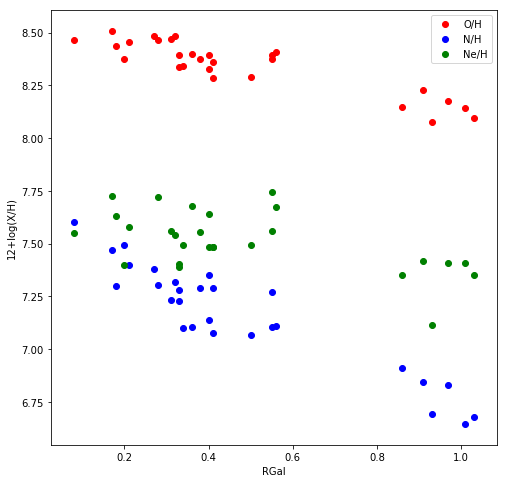

In [28]:
f, ax = plt.subplots(figsize=(8,8))
ax.scatter(Rgal, np.log10(OoH) + 12, label = 'O/H', color='red')
ax.scatter(Rgal, np.log10(NoH) + 12, label = 'N/H', color='blue')
ax.scatter(Rgal, np.log10(NeoH) + 12, label = 'Ne/H', color='green')

ax.legend()
ax.set_xlabel('RGal')
ax.set_ylabel('12+log(X/H)')

### Print out all the atomic data files used in this programm.

In [29]:
for ion in np.sort(list(pn.config.DataFiles.keys())):
    print('{0} -> {1}'.format(ion, pn.config.DataFiles[ion]))

Ar3 -> ['ar_iii_atom_MB09.dat', 'ar_iii_coll_MB09.dat']
H1 -> ['h_i_rec_SH95.hdf5']
He1 -> ['he_i_rec_Pal12-Pal13.hdf5']
N2 -> ['n_ii_atom_FFT04.dat', 'n_ii_coll_T11.dat']
Ne3 -> ['ne_iii_atom_GMZ97.dat', 'ne_iii_coll_McLB00.dat']
O2 -> ['o_ii_atom_FFT04.dat', 'o_ii_coll_Kal09.dat', 'o_ii_rec_SSB17-B-opt.hdf5']
O3 -> ['o_iii_atom_FFT04-SZ00.dat', 'o_iii_coll_SSB14.dat']
S2 -> ['s_ii_atom_PKW09.dat', 's_ii_coll_TZ10.dat']
S3 -> ['s_iii_atom_PKW09.dat', 's_iii_coll_TG99.dat']


### ??? How should one proceed (in principle) to compute properly the error bars?

In [ ]:
# the following is to have the nice style in the Notebook.
# Don't remove this.
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()